In [2]:
import pandas as pd
import numpy as np
import math
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def reduce_pca_by_variance(data: np.ndarray, feature_names: list, variance_threshold: float):
    """
    Performs PCA on n-dimensional data, automatically selecting the minimum
    number of components to explain at least the `variance_threshold`.
    
    This modified version also prints the results of the reduction and
    the top 5 feature contributors for each component.

    Args:
        data: A (n_samples, n_features) NumPy array.
        feature_names: A list of strings corresponding to the feature columns
                       in `data`. (e.g., list(df.columns))
        variance_threshold: The target amount of variance to explain
                            (e.g., 0.95 for 95%).

    Returns:
        A tuple containing:
        - data_transformed (np.ndarray): The data projected onto the
                                         new component space.
        - fitted_pca (PCA): The fitted PCA object, which you can use
                            to inspect the number of components, etc.
    """
    
    if len(feature_names) != data.shape[1]:
        raise ValueError(f"Number of feature_names ({len(feature_names)}) does not "
                         f"match number of data columns ({data.shape[1]}).")

    # 1. Create a PCA object with the variance threshold.
    # By setting n_components to a float, PCA automatically finds
    # the components needed to explain that much variance.
    pca = PCA(n_components=variance_threshold)
    
    # 2. Create a pipeline to first scale the data, then run PCA.
    # Scaling is crucial for PCA to work correctly.
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', pca)
    ])
    
    # 3. Fit the pipeline to the data and transform it
    data_transformed = pipeline.fit_transform(data)
    
    # --- Report print statements ---
    
    # Get the original and new dimensions
    original_dimensions = data.shape[1]
    # We access the fitted pca object from step 2
    new_dimensions = pca.n_components_ 
    
    print("-" * 30)
    print("PCA Dimensionality Reduction Report")
    print("-" * 30)
    print(f"Original dimensions:   {original_dimensions}")
    print(f"New dimensions:        {new_dimensions}")
    print(f"Dimensions reduced by: {original_dimensions - new_dimensions}")
    print("\nVariance explained by each remaining component:")
    
    # pca.explained_variance_ratio_ is an array like [0.5, 0.3, 0.1]
    for i, variance in enumerate(pca.explained_variance_ratio_):
        print(f"  Principal Component {i+1}: {variance * 100:.2f}%")
        
    # Print total variance explained
    total_variance = np.sum(pca.explained_variance_ratio_)
    print(f"\nTotal variance explained: {total_variance * 100:.2f}%")
    print(f"(Target threshold was {variance_threshold * 100:.0f}%)")
    
    # --- New: Top 5 Contributors Report ---
    print("\nTop 5 Contributors per Component:")
    
    # pca.components_ has shape (n_components, n_features)
    for i, component in enumerate(pca.components_):
        print(f"  --- Principal Component {i+1} ---")
        
        # Get indices of the top 5 absolute loadings
        # np.argsort returns indices of smallest to largest
        # We take the last 5, and then reverse them [::-1]
        top_5_indices = np.argsort(np.abs(component))[-5:][::-1]
        
        # Print the feature name and its loading (weight)
        for feature_index in top_5_indices:
            feature_name = feature_names[feature_index]
            loading = component[feature_index]
            print(f"    {feature_name}: {loading:.4f}")
            
    print("-" * 30)
    
    # --- End of report ---
    
    # Return the new data and the fitted PCA object (which is stored in
    # the 'pca' variable) so you can inspect it later.
    return data_transformed, pca


ModuleNotFoundError: No module named 'sklearn'

# Processing

In [ ]:
# Get data to be a numpy array probably
df=pd.read_csv('consolidated_acs_data_clean.csv')
data=np.array(df)
income_index=1  # Example index for income dimension
# Transform the income dimension by logarithmic scale
data[:, income_index] = np.log(data[:, income_index].astype(np.float64))
# Normalize data by dividing by standard deviation by dimension
for i in range(1,data.shape[1]):
    data[:, i] = data[:, i] / np.std(data[:, i])


## Weighting

In [ ]:


# Get column indices
income_index = 1  # per_capita_income
poverty_index = df.columns.get_loc('avg_poverty_ratio')
employment_index = df.columns.get_loc('in_labor_force')
healthcare_index = df.columns.get_loc('Educational services, and health care and social assistance')
education_index = df.columns.get_loc('College or More')
commute_index = df.columns.get_loc('avg_commute_time')
housing_index = df.columns.get_loc('avg_housing_cost_burden')
race_indices = [df.columns.get_loc(col) for col in ['white', 'black', 'asian', 'native', 'pacific islander', 'other']]

# Apply dimension weights
data[:, income_index] *= 0.1225          # Economic Security - Income
data[:, poverty_index] *= 0.0525         # Economic Security - Poverty
data[:, employment_index] *= 0.07        # Economic Security - Employment
data[:, healthcare_index] *= 0.105       # Economic Security - Healthcare
data[:, education_index] *= 0.15         # Education
data[:, commute_index] *= 0.15           # Location Affordability - Transportation
data[:, housing_index] *= 0.15           # Location Affordability - Housing

# Race: distribute 0.2 across 6 race columns
for idx in race_indices:
    data[:, idx] *= 0.2 / 6  # 0.0333 per column



In [ ]:
# Perform PCA, and project onto the top N dimensions so that they explain 50% of the variance
new_data,pca = reduce_pca_by_variance(data[:,1:], list(df.columns)[1:], variance_threshold=0.5)

------------------------------
PCA Dimensionality Reduction Report
------------------------------
Original dimensions:   23
New dimensions:        6
Dimensions reduced by: 17

Variance explained by each remaining component:
  Principal Component 1: 16.07%
  Principal Component 2: 10.11%
  Principal Component 3: 8.43%
  Principal Component 4: 6.79%
  Principal Component 5: 6.32%
  Principal Component 6: 5.67%

Total variance explained: 53.38%
(Target threshold was 50%)

Top 5 Contributors per Component:
  --- Principal Component 1 ---
    College or More: 0.4448
    avg_poverty_ratio: 0.3872
    Under High School: -0.3443
    per_capita_income: 0.2592
    out_labor_force: -0.2370
  --- Principal Component 2 ---
    out_labor_force: -0.4101
    in_labor_force: 0.4101
    white: -0.3803
    pacific islander: -0.3752
    Agriculture, forestry, fishing and hunting, and mining: -0.2772
  --- Principal Component 3 ---
    High School (No College Degree): 0.4196
    avg_housing_cost_burden: -0

As shown, the first component has a distinct identity, namely education, income and poverty, part of the most important factors typically considered as determinant of a person's sociol-economic status. The rest of the components are a mixed of race, education, occupation, and comute time.

In [ ]:
def create_network(data, weights,window_size):
    # First add each data point as a node
    G = nx.Graph()
    for i, point in enumerate(data):
        G.add_node(i, features=point)

    # For each dimension in the data, add edges between points within a certain window size
    
    for dim in range(data.shape[1]):
        weight=weights[dim]
        # Find the max of the current dimension
        dim_values = data[:, dim]
        max_value = np.max(dim_values)
        
        n=int(max_value/window_size) + 1
        
        # this add each marker in the dimesion as a node, so that data points close to it can connect to it
        markers = [window_size * i for i in range(1,n+1)]
        G.add_node(f'{dim,markers[0]:.4}', marker=True, dim=dim, value=markers[0])
        for i in range(1,n+1):
            G.add_node(f'{dim,markers[i]:.4}', marker=True, dim=dim, value=markers[i])
            G.add_edge(f'{dim,markers[i-1]:.4}',f'{dim,markers[i]:.4}', weight=weight)
        
        # Now connect data points to the nearest marker nodes within the window size
        for i, point in enumerate(data):
            point_value = point[dim]
            lower_marker = markers[int(point_value // window_size)]
            G.add_edge(i, f'{dim,lower_marker:.4}', weight=weight)
        
    return G

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

def get_kmeans_partition(data: np.ndarray, weights, n_clusters=14):
    """
    Runs K-means clustering on the input data and returns the loss
    (inertia) and a partition of the data indices by cluster.

    Args:
        data: A (n_samples, n_features) NumPy array.
        n_clusters: The number of clusters (k).

    Returns:
        A tuple containing:
        - loss (float): The inertia (Within-Cluster Sum of Squares).
        - partitions (dict): A dictionary where keys are cluster IDs (0 to k-1)
                             and values are lists of original data indices
                             belonging to that cluster.
    """
    
    # 1. Initialize and fit the K-means model
    # n_init=10 runs the algorithm 10 times and picks the best result
    # random_state=42 ensures the result is reproducible
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    for i in range(weights):
        data[:, i] = data[:, i] * weights[i]
    kmeans.fit(data)

    # 2. Get the loss (inertia)
    # .inertia_ is the WCSS (Within-Cluster Sum of Squares)
    loss = kmeans.inertia_

    # 3. Get the cluster assignment for each data point
    # .labels_ is an array like [0, 1, 1, 0, 2, ...]
    labels = kmeans.labels_

    # 4. Create the partition of indices
    partitions = {i: [] for i in range(n_clusters)}
    for index, cluster_id in enumerate(labels):
        partitions[cluster_id].append(index)

    return loss, partitions

# --- Example Usage ---

# 1. Create a sample NumPy matrix (6 samples, 2 features)
# Let's create two clear clusters

k = 14

# 3. Run the function
total_loss, index_partitions = get_kmeans_partition(new_data,weights, n_clusters=k)



In [ ]:
G=create_network(new_data, weights=[], window_size=0.1)
# Give it a partition from the NC districts
# We can give it several partitions from the recent redistrictings and test the modularity for each.s
partition=[]

In [ ]:
# nx.algorithms.community.louvain_communities(G,weight='weight')
nx.algorithms.community.modularity(G, partition, weight='weight')
nx.algorithms.community.modularity(G, index_partitions, weight='weight')

In [ ]:
import networkx as nx
import pickle
from scipy.sparse import load_npz

# Create graph

# Load adjacency matrix
adj_matrix = load_npz('adjacency_queen_matrix.npz')

# Load mappings
with open('adjacency_queen_mappings.pkl', 'rb') as f:
    mappings = pickle.load(f)
index_to_geoid = mappings['index_to_geoid']

# Get edges from sparse matrix
rows, cols = adj_matrix.nonzero()

# Add edges with your weight
weight = 1.0  # Change this to your desired weight

for i, j in zip(rows, cols):
    if i < j:  # Only add each edge once (undirected)
        geoid1 = index_to_geoid[i]
        geoid2 = index_to_geoid[j]
        G.add_edge(geoid1, geoid2, weight=weight)


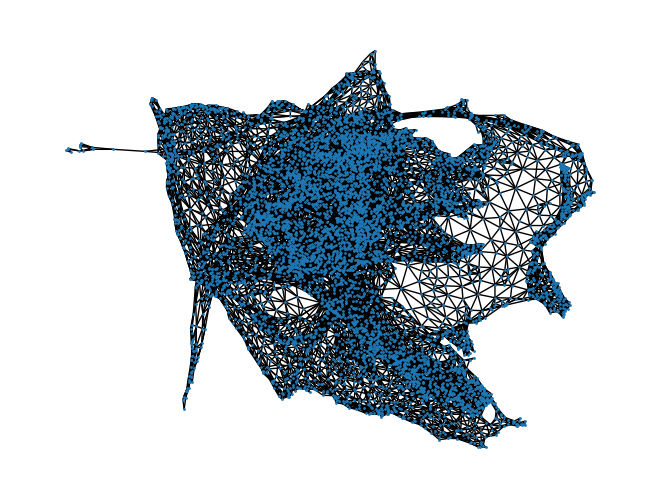

In [ ]:
nx.draw(G,node_size=1)

## Optimization

In [ ]:
import community.community_louvain as community_louvain

# Define problem variables
n = 14 # number of districts
g = 400 # number of block groups in each district
N_G = 7047 # total number of block groups

# Optimization variables
N = 1000 # number of iterations

# Initial guess (optional)


# Louvain
partition = community_louvain.best_partition(G) # has other optional parameters


# # for i in range(N): # total number of times we let louvain go
# for j in distribution: # iterate over each district
#     a = 0
#     # 1. Find neighboring block group that will maximize the modularity score
#     # 2. Swap
#     # 3. Calculate new modularity score
#     # 4. Update modularity scores and districts

# End